In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as pmt
import camb

# Plotting setup

In [2]:
#### Custom style: base configuration

plt.rcParams['axes.titlesize'] = 'large'      # font size of the axes title
plt.rcParams['axes.labelsize'] = 'medium'     # font size of the x and y labels
plt.rcParams['figure.dpi'] = 150              # figure dots per inch
plt.rcParams['xtick.labelsize'] = 'medium'    # font size of the tick labels
plt.rcParams['ytick.labelsize'] = 'medium'    # font size of the tick labels
plt.rcParams['legend.fontsize'] = 'medium'    # font size of legend entries

plt.rcParams['savefig.format'] = 'pdf'        # {png,  ps,  pdf,  svg}
plt.rcParams['savefig.bbox'] = 'tight'        # {tight,  standard}
plt.rcParams['savefig.pad_inches'] = 0.02     # padding to be used,  when bbox is set to 'tight'


In [3]:
#### Custom style: tex

plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True            # use LaTeX for all text handling
plt.rcParams['mathtext.fontset'] = 'cm'       # use Computer Modern font,  matching LaTeX default
plt.rcParams['text.latex.preamble'] = r"\usepackage{siunitx}\DeclareSIUnit\arcmin{arcmin}"  # for roman units

In [4]:
#### Custom style: twocolumn paper context -- size ajustments

plt.rcParams['figure.figsize'] = 3.2,  2.0    # figure size in inches
plt.rcParams['font.size'] = 8.0              # font size used as 'medium'
plt.rcParams['lines.linewidth'] = 1.0        # line width in points
plt.rcParams['lines.markersize'] = 5.6       # marker size,  in points
plt.rcParams['axes.linewidth'] = 0.6         # edge line width

plt.rcParams['xtick.major.size'] = 2.5       # major tick size in points
plt.rcParams['xtick.minor.size'] = 1.5       # minor tick size in points
plt.rcParams['xtick.major.width'] = 0.6      # major tick width in points
plt.rcParams['xtick.minor.width'] = 0.4      # minor tick width in points
plt.rcParams['xtick.major.pad'] = 5.6        # distance to major tick label in points

plt.rcParams['ytick.major.size'] = 2.5       # major tick size in points
plt.rcParams['ytick.minor.size'] = 1.5       # minor tick size in points
plt.rcParams['ytick.major.width'] = 0.6      # major tick width in points
plt.rcParams['ytick.minor.width'] = 0.4      # minor tick width in points
plt.rcParams['ytick.major.pad'] = 5.6        # distance to major tick label in points


In [5]:
fw, fh = plt.rcParams['figure.figsize']

# Colors

In [6]:
c_0064_new = plt.cm.tab20(0)
c_0064_old = plt.cm.tab20(1)
c_2048_new = plt.cm.tab20(2)
c_2048_old = plt.cm.tab20(3)

In [7]:
c_low_new = plt.cm.tab20(0)
c_low_old = plt.cm.tab20(1)
c_big_new = plt.cm.tab20(2)
c_big_old = plt.cm.tab20(3)

In [8]:
c_nofsky = plt.cm.tab20(15)
c_no_apo = plt.cm.tab20(14)
c_intlow = 'C0'
c_intbig = 'C1'
c_gallow = 'C3'
c_ptslow = 'C9'
c_pymstr = 'C6'

# Helper functions

In [9]:
def get_camb_spectra(lmax, H0p=67.5, ombh2p=0.022, omch2p=0.122, mnup=0.06, omkp=0, taup=0.06, Asp=2e-9, nsp=0.965, rp=0, lpap=0):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0p, ombh2=ombh2p, omch2=omch2p, mnu=mnup, omk=omkp, tau=taup)
    pars.InitPower.set_params(As=Asp, ns=nsp, r=rp)
    pars.set_for_lmax(lmax, lens_potential_accuracy=lpap)
    results = camb.get_results(pars)
    cls = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)
    return np.hstack((cls['total'][:lmax+1], np.zeros((lmax+1, 2)))).T

In [10]:
def plotdls(ax, cls, a=0, b=None, norm=True, **kwargs):
    ells = np.arange(len(cls))
    norm = ells[a:b] * (ells[a:b] + 1) / (2 * np.pi) if norm else 1
    ax.plot(ells[a:b], cls[a:b] * norm, **kwargs)
    ax.set_ylabel(r'$D_\ell~/~\unit{\micro\kelvin\squared}$')
    ax.set_xlabel(r'$\ell$')
    return

In [11]:
def null_highell(alm, lmax=2000):
    if len(alm.shape) == 1:
        fl = np.ones_like(alm)
        fl[lmax:] = 0
        alm_out = hp.almxfl(alm, fl)
    elif len(alm.shape) == 2:
        fl = np.ones_like(alm[0])
        fl[lmax:] = 0
        alm_out = np.zeros_like(alm)
        for i in range(alm.shape[0]):
            alm_out[i] = hp.almxfl(alm[i], fl)
    else:
        raise Exception(f"Wrong shape for alm, shape is {alm.shape}.")
    return alm_out

# The CMB power spectrum

In [12]:
labels_v = ['TT', 'EE', 'BB', 'TE', 'TB', 'EB']

In [13]:
# (~1min)
cls_camb = get_camb_spectra(lmax=2048*3-1)
ell = np.arange(0, cls_camb.shape[1])
dls_camb = cls_camb * ell * (ell+1) / (2 * np.pi)
np.random.seed(42)
map_2048, alm_2048 = hp.synfast(cls_camb, 2048, alm=True, new=True, pol=True, pixwin=False)
cls_2048 = hp.anafast(map_2048, pol=True, use_pixel_weights=True)

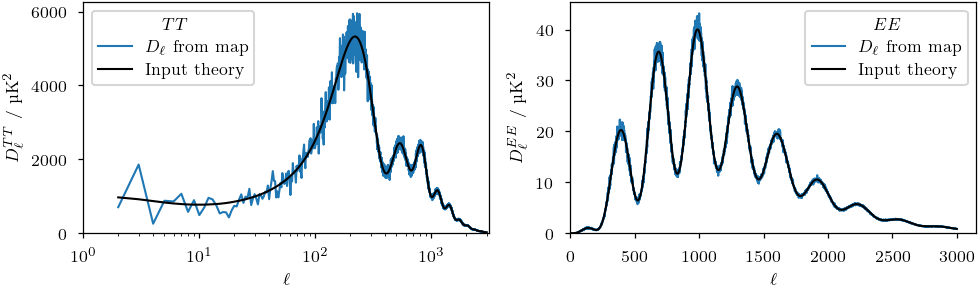

In [14]:
idx = 0
fig, axes = plt.subplots(1, 2, figsize=(2.4*fw, fh))
for idx, ax in enumerate(axes):
    plotdls(ax, cls_2048[idx], label=r'$D_\ell$ from map', a=2, b=3000)
    plotdls(ax, cls_camb[idx], label='Input theory', c='black', a=2, b=3000)
    ax.legend(title=f"${labels_v[idx]}$")
    ax.set_ylim(0)
    ax.set_xlim(0)
    ax.set_ylabel(f"$D_\\ell^{{{labels_v[idx]}}}~/~\\unit{{\\micro\\kelvin\\squared}}$")
axes[0].set_xscale('log')
axes[0].set_xlim(1)
fig.savefig(f"Figures/ClsFromMap.pdf")

# Beam and smoothing

In [15]:
b_low =  5  # arcmin
b_big = 40  # arcmin
bl_low = hp.gauss_beam(np.deg2rad(b_low/60), lmax=3*2048-1, pol=True).T
bl_big = hp.gauss_beam(np.deg2rad(b_big/60), lmax=3*2048-1, pol=True).T

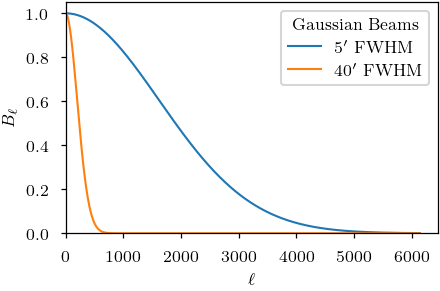

In [16]:
fig, ax = plt.subplots()
ax.plot(bl_low[idx], label=fr"\hphantom{2}\ang{{;{b_low};}} FWHM")
ax.plot(bl_big[idx], label=fr"\ang{{;{b_big};}} FWHM")
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$B_\ell$')
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(title='Gaussian Beams')
fig.savefig(f"Figures/beamplots.pdf")

In [17]:
# (~2min)
np.random.seed(42)
map_2048_smoothed_low = hp.synfast(cls_camb, 2048, pixwin=False, fwhm=np.deg2rad(b_low/60), new=True)
map_2048_smoothed_big = hp.synfast(cls_camb, 2048, pixwin=False, fwhm=np.deg2rad(b_big/60), new=True)
cls_2048_smoothed_low = hp.anafast(map_2048_smoothed_low, use_pixel_weights=True)
cls_2048_smoothed_big = hp.anafast(map_2048_smoothed_big, use_pixel_weights=True)

/tmp/ipykernel_2086739/2607299286.py:9: RuntimeWarning: divide by zero encountered in divide
  plotdls(ax, cls_2048_smoothed_big[idx]/bl_big[idx]**2, a=lmin, b=lmax_2[idx], c=c_big_new, label=fr"FWHM \ang{{;{b_big};}}, $D_\ell/B_\ell^2$")


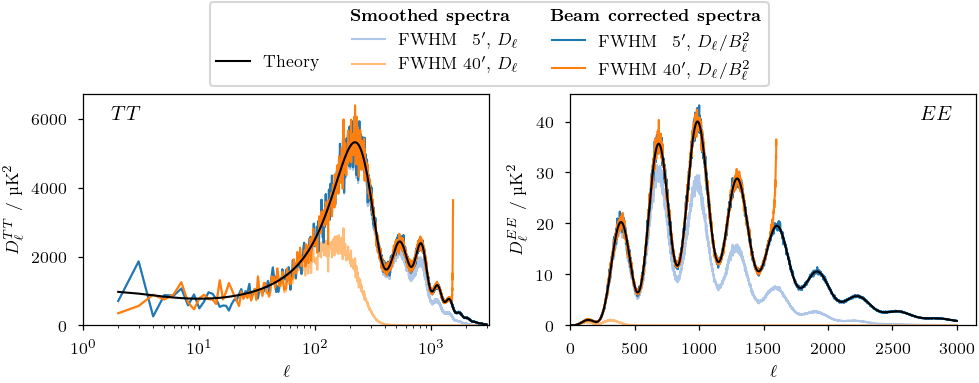

In [18]:
lmin = 2
lmax = 3000
lmax_2 = [1540, 1600]
fig, axes = plt.subplots(1, 2, figsize=(2.4*fw, fh))
for idx, ax in enumerate(axes):
    plotdls(ax, cls_2048_smoothed_low[idx],                a=lmin, b=lmax,        c=c_low_old, label=fr"FWHM \hphantom{2}\ang{{;{b_low};}}, $D_\ell$")
    plotdls(ax, cls_2048_smoothed_big[idx],                a=lmin, b=lmax,        c=c_big_old, label=fr"FWHM \ang{{;{b_big};}}, $D_\ell$")
    plotdls(ax, cls_2048_smoothed_low[idx]/bl_low[idx]**2, a=lmin, b=lmax,        c=c_low_new, label=fr"FWHM \hphantom{2}\ang{{;{b_low};}}, $D_\ell/B_\ell^2$")
    plotdls(ax, cls_2048_smoothed_big[idx]/bl_big[idx]**2, a=lmin, b=lmax_2[idx], c=c_big_new, label=fr"FWHM \ang{{;{b_big};}}, $D_\ell/B_\ell^2$")
    plotdls(ax, cls_camb[idx],                             a=lmin, b=lmax,        c='black',   label='Theory')
    ax.plot([], [], c='w', alpha=0, label=" ")
    ax.plot([], [], c='w', alpha=0, label=r"\textbf{Smoothed spectra}")
    ax.plot([], [], c='w', alpha=0, label=r"\textbf{Beam corrected spectra}")
    ax.set_ylim(0)
    ax.set_xlim(0)
    ax.set_ylabel(f"$D_\\ell^{{{labels_v[idx]}}}~/~\\unit{{\\micro\\kelvin\\squared}}$")
    ax.text(0.9 if idx else 0.1, 0.95, f"${labels_v[idx]}$", va='top', ha='center', transform=ax.transAxes, fontsize='large')
axes[0].set_xscale('log')
axes[0].set_xlim(1)
handles, labels = ax.get_legend_handles_labels()
order = [5, 5, 4, 6, 0, 1, 7, 2, 3]
leg = axes[0].legend(
    np.array(handles)[order],
    np.array(labels)[order],
    ncol=3,
    loc='lower center',
    bbox_to_anchor=(1, 1),
)
for i, col in enumerate(leg._legend_handle_box.get_children()):
    for j, row in enumerate(col.get_children()):
        if i >0 and j == 0:
            row.get_children()[0].set_width(-7)
fig.savefig("Figures/deconvolved_beam_smoothed_lmax3000")

# Pixel window function

In [19]:
pw0064 = hp.pixwin(  64, pol=True, lmax=3*  64-1)
pw2048 = hp.pixwin(2048, pol=True, lmax=3*2048-1)

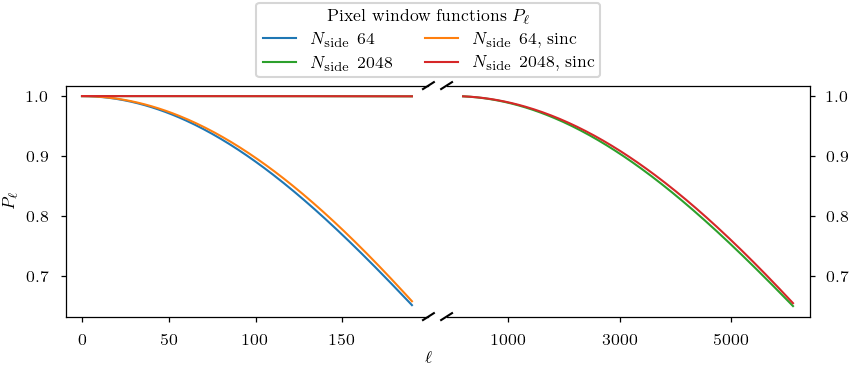

In [20]:
lmin = 0
lmax = 3 * 64 - 1
ell = np.linspace(lmin, lmax*2, lmax*2+1, dtype=int)
ell[lmax:] = np.linspace(lmax, lmax*2048/64, lmax+1, dtype=int)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(2*fw, fh), gridspec_kw=dict(wspace=0.05))#, width_ratios=(1, 3)))
ax1.plot(ell[lmin:lmax], pw0064[0][lmin:lmax], label=r'$N_\mathrm{side}$ 64')
ax1.plot(ell[lmin:lmax], pw2048[0][ell[lmin:lmax]], label=r'$N_\mathrm{side}$ 2048', c='C2')
ax1.plot(ell[lmin:lmax], np.sinc(ell[lmin:lmax]*hp.nside2resol(64)/2/np.pi), label=r'$N_\mathrm{side}$ 64, sinc')
ax1.plot(ell[lmin:lmax], np.sinc(ell[lmin:lmax]*hp.nside2resol(2048)/2/np.pi), label=r'$N_\mathrm{side}$ 2048, sinc', c='C3')
ax2.plot(ell[lmax:], pw2048[0][ell[lmax:]], c='C2')
ax2.plot(ell[lmax:], np.sinc(ell[lmax:]*hp.nside2resol(2048)/2/np.pi), c='C3')
ax2.set_xticks((1000, 3000, 5000))

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()
ax2.tick_params(labelleft=False)
ax2.tick_params(labelright=True)
# ax1.set_ylim(0)
ax1.set_ylabel(r'$P_\ell$')
ax1.set_xlabel(r'$\ell$')#, ha='right')
ax1.xaxis.set_label_coords(1, -0.15)
d = 0.015  # how big to make the diagonal lines in axes coordinates
ax1.plot((1-d, 1+d), (0-d, 0+d), transform=ax1.transAxes, c='k', clip_on=False)
ax1.plot((1-d, 1+d), (1-d, 1+d), transform=ax1.transAxes, c='k', clip_on=False)
ax2.plot((0-d, 0+d), (1-d, 1+d), transform=ax2.transAxes, c='k', clip_on=False)
ax2.plot((0-d, 0+d), (0-d, 0+d), transform=ax2.transAxes, c='k', clip_on=False)
ax1.legend(ncol=2, title=r'Pixel window functions $P_\ell$', loc='lower center', bbox_to_anchor=(1, 1))
# fig.savefig("Figures/pixwin_final.pdf")

In [21]:
ell = np.arange(0, 2e4+1, 1, dtype=int)
pw0064_sinc = np.sinc(ell*hp.nside2resol(  64)/2/np.pi)
pw2048_sinc = np.sinc(ell*hp.nside2resol(2048)/2/np.pi)

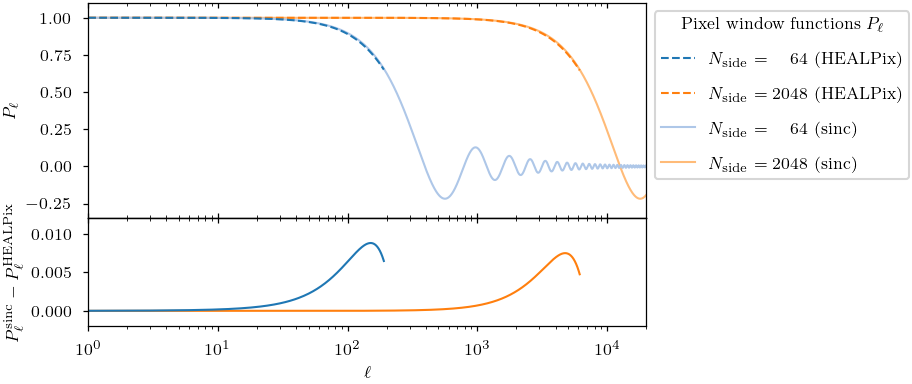

In [22]:
lmin = 1
lmax = 3 * np.array([64, 2048]) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(1.5*fw, 1.4*fh), sharex=True, gridspec_kw=dict(hspace=0, height_ratios=(2, 1)))
ax1.semilogx(ell[lmin:],        pw2048_sinc[lmin:],      c=c_2048_old,          label=r'$N_\mathrm{side}=2048$ (sinc)')
ax1.semilogx(ell[lmin:],        pw0064_sinc[lmin:],      c=c_0064_old,          label=r'$N_\mathrm{side}=\hphantom{20}64$ (sinc)')
ax1.semilogx(ell[lmin:lmax[1]], pw2048[0][lmin:lmax[1]], c=c_2048_new, ls='--', label=r'$N_\mathrm{side}=2048$ (HEALPix)')
ax1.semilogx(ell[lmin:lmax[0]], pw0064[0][lmin:lmax[0]], c=c_0064_new, ls='--', label=r'$N_\mathrm{side}=\hphantom{20}64$ (HEALPix)')

ax2.semilogx(ell[lmin:lmax[1]], np.sinc(ell[lmin:lmax[1]]*hp.nside2resol(2048)/2/np.pi)-pw2048[0][lmin:lmax[1]], c=c_2048_new)
ax2.semilogx(ell[lmin:lmax[0]], np.sinc(ell[lmin:lmax[0]]*hp.nside2resol(  64)/2/np.pi)-pw0064[0][lmin:lmax[0]], c=c_0064_new)

axs = ax2.secondary_xaxis('top')
ax1.set_xlim(lmin, ell[-1])
ax1.set_ylim(-0.35, 1.10)
ax2.set_ylim(-0.002, 0.012)
ax1.tick_params(axis='x', which='both', top=True, direction='in')
axs.tick_params(axis='x', which='both', top=True, direction='in')
axs.set_xticklabels([])
ax2.set_yticks(np.arange(0, 0.012+0.002, 0.005))

ax2.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$P_\ell$')
ax2.set_ylabel(r'$P_\ell^\mathrm{sinc}-P_\ell^\mathrm{HEALPix}$')
ax1.legend(
    title=r'Pixel window functions $P_\ell$', 
    loc='upper left', 
    bbox_to_anchor=(1, 1),
    reverse=True,
    labelspacing=1.1,
)

fig.savefig("Figures/pixwin.pdf")

In [23]:
np.random.seed(42)
map_0064_pw = hp.synfast(cls_camb, 64, alm=False, pixwin=True, fwhm=0.0, new=True)
cls_0064_pw = hp.anafast(map_0064_pw, use_pixel_weights=True)

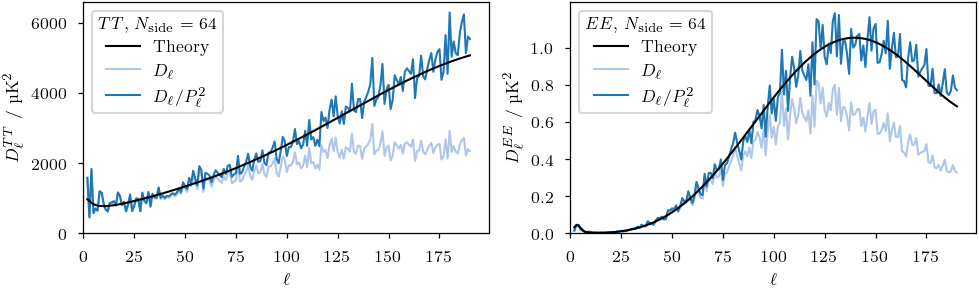

In [24]:
lmin = 2
lmax = 3*64-1
fig, axes = plt.subplots(1, 2, figsize=(2.4*fw, fh))
for idx, ax in enumerate(axes):
    plotdls(ax, cls_0064_pw[idx],              a=lmin, b=lmax, c=c_0064_old, label=r'$D_\ell$')
    plotdls(ax, cls_0064_pw[idx]/pw0064[0]**2, a=lmin, b=lmax, c=c_0064_new, label=r'$D_\ell/P_\ell^2$')
    plotdls(ax, cls_camb[idx],                 a=lmin, b=lmax, c='black',    label='Theory')
    ax.set_xlim(0)
    ax.set_ylim(0)
    handles, labels = ax.get_legend_handles_labels()
    order = [2, 0, 1]
    leg = ax.legend(
        np.array(handles)[order],
        np.array(labels)[order],
        title=f"${labels_v[idx]}$, $N_\\mathrm{{side}}=64$",
        ncol=1, 
    )
    ax.set_ylabel(f"$D_\\ell^{{{labels_v[idx]}}}~/~\\unit{{\\micro\\kelvin\\squared}}$")
axes[1].set_yticks(np.arange(0, 1.1, 0.2))
fig.savefig("Figures/cls_pixwin.pdf")


In [25]:
# (~8s)
nside_low = 64
map_low_wrong_udg = hp.ud_grade(map_2048, nside_low)
map_low_wrong_a2m = hp.alm2map(alm_2048,                                   nside_low, pixwin=False, fwhm=0.0, sigma=None)
map_low_right_a2m = hp.alm2map(null_highell(alm_2048, lmax=3*nside_low-1), nside_low, pixwin=False, fwhm=0.0, sigma=None)
map_low_tight_a2m = hp.alm2map(null_highell(alm_2048, lmax=2*nside_low),   nside_low, pixwin=False, fwhm=0.0, sigma=None)
cls_low_wrong_udg = hp.anafast(map_low_wrong_udg, use_pixel_weights=True)
cls_low_wrong_a2m = hp.anafast(map_low_wrong_a2m, use_pixel_weights=True)
cls_low_right_a2m = hp.anafast(map_low_right_a2m, use_pixel_weights=True)
cls_low_tight_a2m = hp.anafast(map_low_tight_a2m, use_pixel_weights=True)


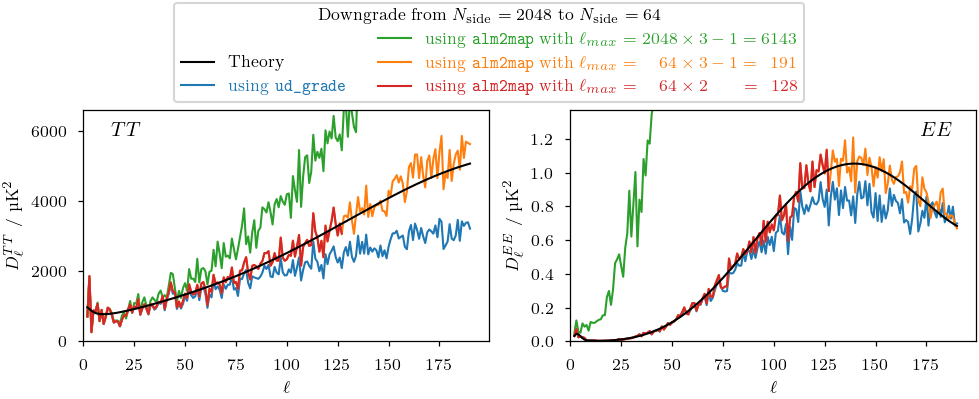

In [26]:
lmin = 2
lmax = 64 * 3 - 1
fig, axes = plt.subplots(1, 2, figsize=(2.4*fw, fh))
for idx, ax in enumerate(axes):
    plotdls(ax, cls_low_wrong_udg[idx], a=lmin, b=lmax, c='C0', label=r"using \texttt{ud\_grade}")
    plotdls(ax, cls_low_wrong_a2m[idx], a=lmin, b=lmax, c='C2', label=r"using \texttt{alm2map} with $\ell_{max}=2048\times3-1=6143$")
    plotdls(ax, cls_low_right_a2m[idx], a=lmin, b=lmax, c='C1', label=r"using \texttt{alm2map} with $\ell_{max}=\hphantom{20}64\times3-1=\hphantom{6}191$")
    plotdls(ax, cls_low_tight_a2m[idx], a=lmin, b=2*64, c='C3', label=r"using \texttt{alm2map} with $\ell_{max}=\hphantom{20}64\times2\hphantom{-16}=\hphantom{6}128$")
    plotdls(ax, cls_camb[idx],               a=lmin, b=lmax, c='k',  label=r"Theory")
    ax.plot([], [], c='w', alpha=0, label=" ")
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [5, 4, 0, 1, 2, 3]
    ax.set_ylim(0, dls_camb[idx][lmin:lmax].max()*1.3)
    ax.set_xlim(0)
    ax.set_ylabel(f"$D_\\ell^{{{labels_v[idx]}}}~/~\\unit{{\\micro\\kelvin\\squared}}$")
    ax.text(0.9 if idx else 0.1, 0.95, f"${labels_v[idx]}$", va='top', ha='center', transform=ax.transAxes, fontsize='large')
axes[1].set_yticks(np.arange(0, 1.3, 0.2))
axes[0].legend(
    np.array(handles)[order],
    np.array(labels)[order],
    title=r"Downgrade from $N_\mathrm{side}=2048$ to $N_\mathrm{side}=64$", 
    ncol=2, 
    loc='lower center', 
    bbox_to_anchor=(1, 1),
    labelcolor='linecolor',
)
fig.savefig("Figures/downgrade64_comp.pdf")

# Noise

In [27]:
nside_noise = hp.npix2nside(map_2048.shape[1])
theta_r_rad = hp.nside2resol(nside_noise)
theta_r_deg = np.rad2deg(theta_r_rad)
theta_r_arcmin = theta_r_deg * 60

In [28]:
noise_muK_arcmin = 30
noise_muK_rad = np.deg2rad(noise_muK_arcmin / 60)
noise_pix_muK = noise_muK_rad / theta_r_rad
cls_2048_noise = noise_muK_rad**2 * np.ones_like(cls_2048)  # in micro-Kelvin^2


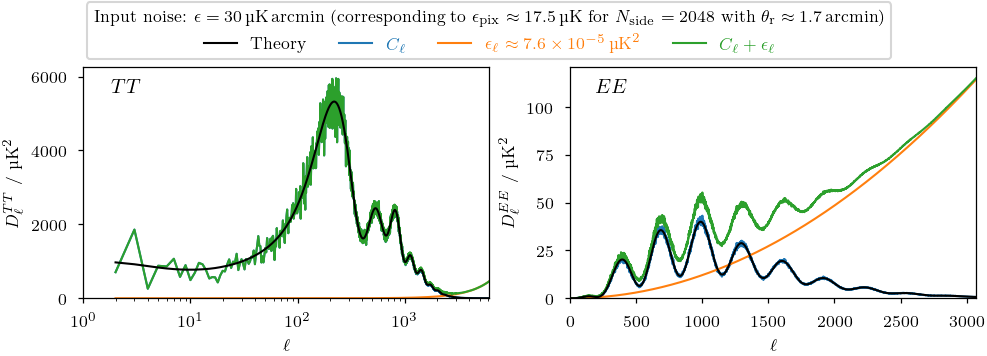

In [29]:
lmin = 2
lmax = np.array([3*2048, 3*2048//2])
fig, axes = plt.subplots(1, 2, figsize=(2.4*fw, fh))
for idx, ax in enumerate(axes):
    plotdls(ax, cls_2048[idx],                     a=lmin, b=lmax[idx], label=fr"$C_\ell$")
    plotdls(ax, cls_2048_noise[idx],               a=lmin, b=lmax[idx], label=fr"$\epsilon_\ell\approx\SI{{{cls_2048_noise[0, 0]:.2g}}}{{\micro\kelvin\squared}}$")
    plotdls(ax, cls_2048[idx]+cls_2048_noise[idx], a=lmin, b=lmax[idx], label=fr"$C_\ell+\epsilon_\ell$")
    plotdls(ax, cls_camb[idx], color='black',      a=lmin, b=lmax[idx], label=fr"Theory")
    ax.set_ylim(0)
    ax.set_xlim(0, lmax[idx])
    ax.set_ylabel(f"$D_\\ell^{{{labels_v[idx]}}}~/~\\unit{{\\micro\\kelvin\\squared}}$")
    ax.text(0.1, 0.95, f"${labels_v[idx]}$", va='top', ha='center', transform=ax.transAxes, fontsize='large')
axes[0].set_xscale('log')
axes[0].set_xlim(1)
handles, labels = ax.get_legend_handles_labels()
order = [-1, 0, 1, 2]
axes[0].legend(
    np.array(handles)[order],
    np.array(labels)[order],
    title=fr"Input noise: $\epsilon=\SI{{{noise_muK_arcmin}}}{{\micro\kelvin\arcmin}}$ (corresponding to $\epsilon_\mathrm{{pix}}\approx\SI{{{noise_pix_muK:.1f}}}{{\micro\kelvin}}$ for $N_\mathrm{{side}}={nside_noise}$ with $\theta_\mathrm{{r}}\approx\SI{{{theta_r_arcmin:.1f}}}{{\arcmin}}$)",
    ncol=4,
    loc='lower center',
    bbox_to_anchor=(1, 1),
    labelcolor='linecolor',
)
fig.savefig(f"Figures/noise_{noise_muK_arcmin}muKarcmin.pdf")


# Masks

In [30]:
# Dowloadable from PLA

mask_pts_no_apo = hp.read_map("../LFI_Mask_PointSrc_2048_R2.00.fits")
mask_gal_no_apo = hp.read_map("../HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=4)  # field=4 mean 80% fsky
mask_int_no_apo = hp.read_map("../COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits")
# mask_pol_no_apo = hp.read_map("../COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits")

In [31]:
alow = 0.5  # deg
abig = 5.0  # deg

In [32]:
# mask_pts_apolow = pmt.mask_apodization(mask_pts_no_apo, aposize=alow, apotype="C1")  # ~40s for 0.5deg
# mask_pts_apobig = pmt.mask_apodization(mask_pts_no_apo, aposize=abig, apotype="C1")
# mask_gal_apolow = pmt.mask_apodization(mask_gal_no_apo, aposize=alow, apotype="C1")  # ~30s for 0.5deg
# mask_gal_apobig = pmt.mask_apodization(mask_gal_no_apo, aposize=abig, apotype="C1")
# mask_int_apolow = pmt.mask_apodization(mask_int_no_apo, aposize=alow, apotype="C1")  # ~30s for 0.5deg
# mask_int_apobig = pmt.mask_apodization(mask_int_no_apo, aposize=abig, apotype="C1")  # ~40min for 5.0deg
# # mask_pol_apolow = pmt.mask_apodization(mask_pol_no_apo, aposize=alow, apotype="C1")  # ~30s for 0.5deg
# # mask_pol_apobig = pmt.mask_apodization(mask_pol_no_apo, aposize=abig, apotype="C1")
# hp.write_map(filename=f"../LFI_Mask_PointSrc-apo{alow:.1f}deg_2048_R2.00.fits", m=mask_pts_apolow, overwrite=True)
# hp.write_map(filename=f"../LFI_Mask_PointSrc-apo{abig:.1f}deg_2048_R2.00.fits", m=mask_pts_apobig, overwrite=True)
# hp.write_map(filename=f"../HFI_Mask_GalPlane-apo{alow:.1f}deg_2048_R2.00.fits", m=mask_gal_apolow, overwrite=True)
# hp.write_map(filename=f"../HFI_Mask_GalPlane-apo{abig:.1f}deg_2048_R2.00.fits", m=mask_gal_apobig, overwrite=True)
# hp.write_map(filename=f"../COM_Mask_CMB-common-Mask-Int-apo{alow:.1f}deg_2048_R3.00.fits", m=mask_int_apolow, overwrite=True)
# hp.write_map(filename=f"../COM_Mask_CMB-common-Mask-Int-apo{abig:.1f}deg_2048_R3.00.fits", m=mask_int_apobig, overwrite=True)
# # hp.write_map(filename=f"../COM_Mask_CMB-common-Mask-Pol-apo{alow:.1f}deg_2048_R3.00.fits", m=mask_pol_apolow, overwrite=True)
# # hp.write_map(filename=f"../COM_Mask_CMB-common-Mask-Pol-apo{abig:.1f}deg_2048_R3.00.fits", m=mask_pol_apobig, overwrite=True)

mask_pts_apolow = hp.read_map(filename=f"../LFI_Mask_PointSrc-apo{alow:.1f}deg_2048_R2.00.fits")
mask_pts_apobig = hp.read_map(filename=f"../LFI_Mask_PointSrc-apo{abig:.1f}deg_2048_R2.00.fits")
mask_gal_apolow = hp.read_map(filename=f"../HFI_Mask_GalPlane-apo{alow:.1f}deg_2048_R2.00.fits")
mask_gal_apobig = hp.read_map(filename=f"../HFI_Mask_GalPlane-apo{abig:.1f}deg_2048_R2.00.fits")
mask_int_apolow = hp.read_map(filename=f"../COM_Mask_CMB-common-Mask-Int-apo{alow:.1f}deg_2048_R3.00.fits")
mask_int_apobig = hp.read_map(filename=f"../COM_Mask_CMB-common-Mask-Int-apo{abig:.1f}deg_2048_R3.00.fits")
# mask_pol_apolow = hp.read_map(filename=f"../COM_Mask_CMB-common-Mask-Pol-apo{alow:.1f}deg_2048_R3.00.fits")
# mask_pol_apobig = hp.read_map(filename=f"../COM_Mask_CMB-common-Mask-Pol-apo{abig:.1f}deg_2048_R3.00.fits")


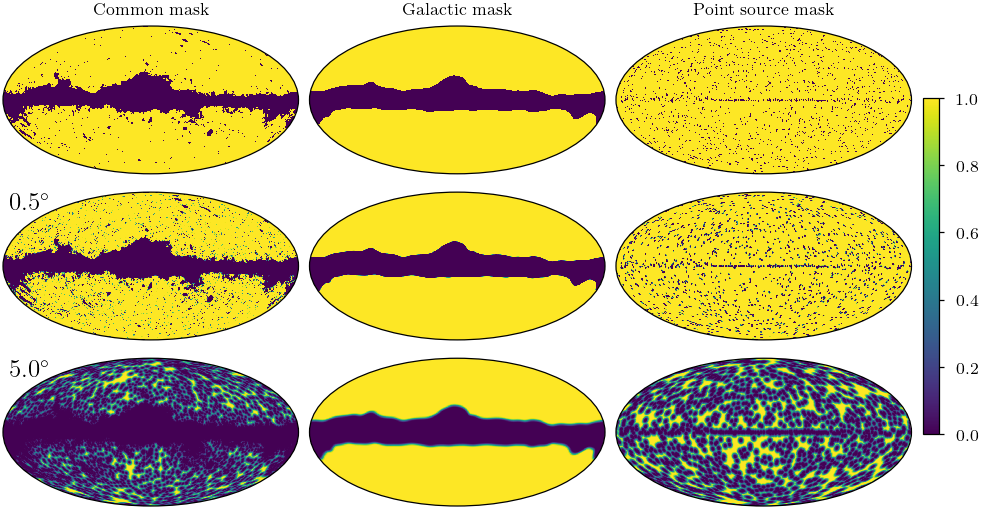

In [33]:
# (~30s)
fig = plt.figure(figsize=(2.4*fw, 1.8*fh))
hp.projview(mask_int_no_apo, fig=fig, sub=331, cbar=False, fontsize=dict(title='medium'), title="Common mask")
hp.projview(mask_gal_no_apo, fig=fig, sub=332, cbar=False, fontsize=dict(title='medium'), title="Galactic mask")
hp.projview(mask_pts_no_apo, fig=fig, sub=333, cbar=False, fontsize=dict(title='medium'), title="Point source mask")
hp.projview(mask_int_apolow, fig=fig, sub=334, cbar=False, fontsize=dict(title='medium'), llabel=fr"\ang{{{alow};;}}")
hp.projview(mask_gal_apolow, fig=fig, sub=335, cbar=False, fontsize=dict(title='medium'))#, llabel=fr"\ang{{{alow};;}}")
hp.projview(mask_pts_apolow, fig=fig, sub=336, cbar=False, fontsize=dict(title='medium'))#, llabel=fr"\ang{{{alow};;}}")
hp.projview(mask_int_apobig, fig=fig, sub=337, cbar=False, fontsize=dict(title='medium'), llabel=fr"\ang{{{abig};;}}")
hp.projview(mask_gal_apobig, fig=fig, sub=338, cbar=False, fontsize=dict(title='medium'))#, llabel=fr"\ang{{{abig};;}}")
hp.projview(mask_pts_apobig, fig=fig, sub=339, cbar=False, fontsize=dict(title='medium'))#, llabel=fr"\ang{{{abig};;}}")
fig.tight_layout()
im = fig.axes[0].collections[0]
fig.colorbar(im, ax=fig.axes, shrink=0.7, pad=0.01)
fig.savefig(f"Figures/mask_types_{alow}_{abig}.pdf")


In [34]:
# (~5min)
cls_pts_no_apo = hp.anafast(map_2048 * mask_pts_no_apo, use_pixel_weights=True)
cls_pts_apolow = hp.anafast(map_2048 * mask_pts_apolow, use_pixel_weights=True)
cls_pts_apobig = hp.anafast(map_2048 * mask_pts_apobig, use_pixel_weights=True)
cls_gal_no_apo = hp.anafast(map_2048 * mask_gal_no_apo, use_pixel_weights=True)
cls_gal_apolow = hp.anafast(map_2048 * mask_gal_apolow, use_pixel_weights=True)
cls_gal_apobig = hp.anafast(map_2048 * mask_gal_apobig, use_pixel_weights=True)
cls_int_no_apo = hp.anafast(map_2048 * mask_int_no_apo, use_pixel_weights=True)
cls_int_apolow = hp.anafast(map_2048 * mask_int_apolow, use_pixel_weights=True)
cls_int_apobig = hp.anafast(map_2048 * mask_int_apobig, use_pixel_weights=True)
# cls_pol_no_apo = hp.anafast(map_2048 * mask_pol_no_apo, use_pixel_weights=True)
# cls_pol_apolow = hp.anafast(map_2048 * mask_pol_apolow, use_pixel_weights=True)
# cls_pol_apobig = hp.anafast(map_2048 * mask_pol_apobig, use_pixel_weights=True)


In [35]:
fsky_int_no_apo = np.sum(mask_int_no_apo**2) / mask_int_no_apo.size
fsky_int_apolow = np.sum(mask_int_apolow**2) / mask_int_apolow.size
fsky_int_apobig = np.sum(mask_int_apobig**2) / mask_int_apobig.size
fsky_pts_no_apo = np.sum(mask_pts_no_apo**2) / mask_pts_no_apo.size
fsky_pts_apolow = np.sum(mask_pts_apolow**2) / mask_pts_apolow.size
fsky_pts_apobig = np.sum(mask_pts_apobig**2) / mask_pts_apobig.size
fsky_gal_no_apo = np.sum(mask_gal_no_apo**2) / mask_gal_no_apo.size
fsky_gal_apolow = np.sum(mask_gal_apolow**2) / mask_gal_apolow.size
fsky_gal_apobig = np.sum(mask_gal_apobig**2) / mask_gal_apobig.size
# fsky_pol_no_apo = np.sum(mask_pol_no_apo**2) / mask_pol_no_apo.size
# fsky_pol_apolow = np.sum(mask_pol_apolow**2) / mask_pol_apolow.size
# fsky_pol_apobig = np.sum(mask_pol_apobig**2) / mask_pol_apobig.size


/tmp/ipykernel_2086739/3353136364.py:6: RuntimeWarning: invalid value encountered in divide
  plotdls(ax, cls_int_no_apo[idx] / cls_2048[idx],                   a=lmin, b=lmax, norm=False, c=c_nofsky, alpha=0.9, label=fr"Without $f_\mathrm{{sky}}$ correction")
/tmp/ipykernel_2086739/3353136364.py:7: RuntimeWarning: invalid value encountered in divide
  plotdls(ax, cls_int_no_apo[idx] / cls_2048[idx] / fsky_int_no_apo, a=lmin, b=lmax, norm=False, c=c_no_apo, alpha=0.9, label=fr"Mask without apodisation")
/tmp/ipykernel_2086739/3353136364.py:8: RuntimeWarning: invalid value encountered in divide
  plotdls(ax, cls_int_apobig[idx] / cls_2048[idx] / fsky_int_apobig, a=lmin, b=lmax, norm=False, c=c_intbig, alpha=0.7, label=fr"Mask with \ang{{{abig};;}} apodisation length")
/tmp/ipykernel_2086739/3353136364.py:9: RuntimeWarning: invalid value encountered in divide
  plotdls(ax, cls_int_apolow[idx] / cls_2048[idx] / fsky_int_apolow, a=lmin, b=lmax, norm=False, c=c_intlow, alpha=0.7, label=fr"M

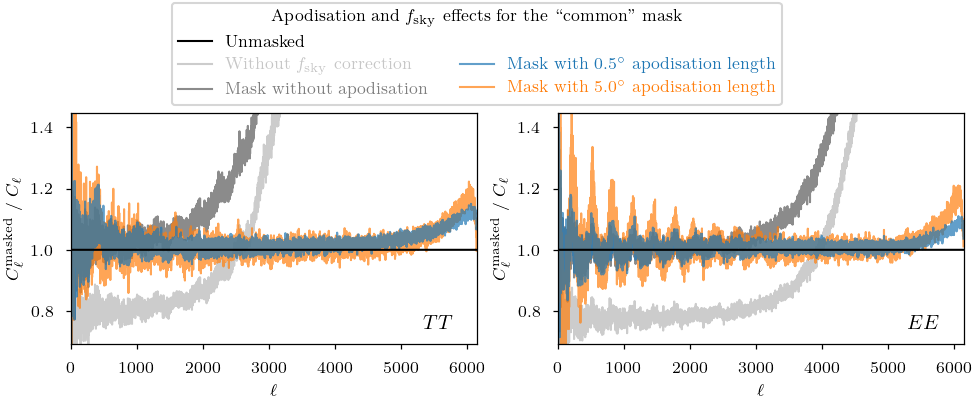

In [36]:
lmin = 2
lmax = 2048 * 3

fig, axes = plt.subplots(1, 2, figsize=(2.4*fw, fh), sharex=True)
for idx, ax in enumerate(axes):
    plotdls(ax, cls_int_no_apo[idx] / cls_2048[idx],                   a=lmin, b=lmax, norm=False, c=c_nofsky, alpha=0.9, label=fr"Without $f_\mathrm{{sky}}$ correction")
    plotdls(ax, cls_int_no_apo[idx] / cls_2048[idx] / fsky_int_no_apo, a=lmin, b=lmax, norm=False, c=c_no_apo, alpha=0.9, label=fr"Mask without apodisation")
    plotdls(ax, cls_int_apobig[idx] / cls_2048[idx] / fsky_int_apobig, a=lmin, b=lmax, norm=False, c=c_intbig, alpha=0.7, label=fr"Mask with \ang{{{abig};;}} apodisation length")
    plotdls(ax, cls_int_apolow[idx] / cls_2048[idx] / fsky_int_apolow, a=lmin, b=lmax, norm=False, c=c_intlow, alpha=0.7, label=fr"Mask with \ang{{{alow};;}} apodisation length")
    plotdls(ax, cls_2048[idx]       / cls_2048[idx],                   a=lmin, b=lmax, norm=False, c='black',  alpha=1.0, label=fr"Unmasked")
    ax.plot([], [], c='w', alpha=0, label=" ")
    ax.set_xlim(0, lmax)
    ax.set_ylim(10**-0.16, 10**0.16)
    ax.set_ylabel(f'$C_\\ell^\\mathrm{{masked}}~/~C_\\ell$')
    ax.text(0.9, 0.05, f"${labels_v[idx]}$", va='bottom', ha='center', transform=ax.transAxes, fontsize='large')
handles, labels = ax.get_legend_handles_labels()
order = [-2, 0, 1, -1, 3, 2]
axes[0].legend(
    np.array(handles)[order],
    np.array(labels)[order],
    title=r"Apodisation and $f_\mathrm{sky}$ effects for the ``common'' mask",
    ncol=2,
    loc='lower center',
    bbox_to_anchor=(1, 1),
    labelcolor='linecolor',
)

fig.savefig(f"Figures/cls_apodisation_diff_{alow}_{abig}.pdf")


/tmp/ipykernel_2086739/484439662.py:6: RuntimeWarning: invalid value encountered in divide
  plotdls(ax, cls_gal_apolow[idx]/cls_2048[idx]/fsky_gal_apolow, a=lmin, b=lmax, norm=False, c=c_gallow, alpha=0.7, label=fr"Galactic mask ($f_\mathrm{{sky}}\approx\SI{{{100*fsky_gal_apolow:.0f}}}{{\percent}}$)")
/tmp/ipykernel_2086739/484439662.py:7: RuntimeWarning: invalid value encountered in divide
  plotdls(ax, cls_pts_apolow[idx]/cls_2048[idx]/fsky_pts_apolow, a=lmin, b=lmax, norm=False, c=c_ptslow, alpha=0.7, label=fr"Point source mask ($f_\mathrm{{sky}}\approx\SI{{{100*fsky_pts_apolow:.0f}}}{{\percent}}$)")
/tmp/ipykernel_2086739/484439662.py:8: RuntimeWarning: invalid value encountered in divide
  plotdls(ax, cls_2048[idx]      /cls_2048[idx],                 a=lmin, b=lmax, norm=False, c='black',  alpha=1.0, label=r"Unmasked")


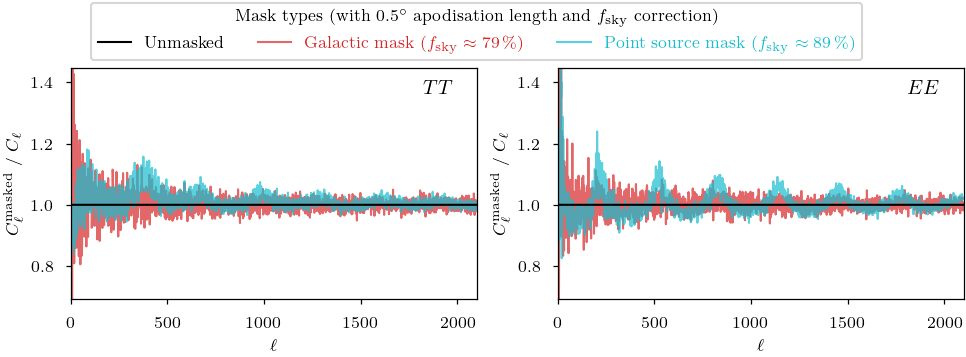

In [37]:
lmin = 2
lmax = 2100

fig, axes = plt.subplots(1, 2, figsize=(2.4*fw, fh), sharex=True)
for idx, ax in enumerate(axes):
    plotdls(ax, cls_gal_apolow[idx]/cls_2048[idx]/fsky_gal_apolow, a=lmin, b=lmax, norm=False, c=c_gallow, alpha=0.7, label=fr"Galactic mask ($f_\mathrm{{sky}}\approx\SI{{{100*fsky_gal_apolow:.0f}}}{{\percent}}$)")
    plotdls(ax, cls_pts_apolow[idx]/cls_2048[idx]/fsky_pts_apolow, a=lmin, b=lmax, norm=False, c=c_ptslow, alpha=0.7, label=fr"Point source mask ($f_\mathrm{{sky}}\approx\SI{{{100*fsky_pts_apolow:.0f}}}{{\percent}}$)")
    plotdls(ax, cls_2048[idx]      /cls_2048[idx],                 a=lmin, b=lmax, norm=False, c='black',  alpha=1.0, label=r"Unmasked")
    ax.set_xlim(0, lmax)
    ax.set_ylim(10**-0.16, 10**0.16)
    ax.set_ylabel(f"$C_\\ell^\\mathrm{{masked}}~/~C_\\ell$")
    ax.text(0.9, 0.95, f"${labels_v[idx]}$", va='top', ha='center', transform=ax.transAxes, fontsize='large')
handles, labels = ax.get_legend_handles_labels()
order = [-1, 0, 1]
axes[0].legend(
    np.array(handles)[order],
    np.array(labels)[order],
    title=fr"Mask types (with \ang{{{alow};;}} apodisation length and $f_\mathrm{{sky}}$ correction)",
    ncol=3,
    loc='lower center',
    bbox_to_anchor=(1, 1),
    labelcolor='linecolor',
)

fig.savefig(f"Figures/cls_mask_type_diff_{alow}.pdf")


# Healpy vs NaMaster

In [38]:
# # (~40min)
# # Initialize binning scheme with 4 ells per bandpower
# b = pmt.NmtBin.from_nside_linear(nside=hp.npix2nside(map_2048.shape[1]), nlb=4)
#
# # Read healpix maps and initialize a spin-0 (~1min) and spin-2 (~2min) field
# f_0_int_no_apo = pmt.NmtField(mask_int_no_apo, map_2048[0:1])
# f_2_int_no_apo = pmt.NmtField(mask_int_no_apo, map_2048[1:3])
# f_0_int_apolow = pmt.NmtField(mask_int_apolow, map_2048[0:1])
# f_2_int_apolow = pmt.NmtField(mask_int_apolow, map_2048[1:3])
# f_0_pts_no_apo = pmt.NmtField(mask_pts_no_apo, map_2048[0:1])
# f_2_pts_no_apo = pmt.NmtField(mask_pts_no_apo, map_2048[1:3])
# f_0_pts_apolow = pmt.NmtField(mask_pts_apolow, map_2048[0:1])
# f_2_pts_apolow = pmt.NmtField(mask_pts_apolow, map_2048[1:3])
#
# # Compute MASTER estimator
# c00_pts_no_apo = pmt.compute_full_master(f_0_pts_no_apo, f_0_pts_no_apo, b)  # spin-0 x spin-0 (~2min)
# c22_pts_no_apo = pmt.compute_full_master(f_2_pts_no_apo, f_2_pts_no_apo, b)  # spin-2 x spin-2 (~4min)
# c00_pts_apolow = pmt.compute_full_master(f_0_pts_apolow, f_0_pts_apolow, b)  # spin-0 x spin-0 (~2min)
# c22_pts_apolow = pmt.compute_full_master(f_2_pts_apolow, f_2_pts_apolow, b)  # spin-2 x spin-2 (~4min)
# c00_int_no_apo = pmt.compute_full_master(f_0_int_no_apo, f_0_int_no_apo, b)  # spin-0 x spin-0 (~2min)
# c22_int_no_apo = pmt.compute_full_master(f_2_int_no_apo, f_2_int_no_apo, b)  # spin-2 x spin-2 (~4min)
# c00_int_apolow = pmt.compute_full_master(f_0_int_apolow, f_0_int_apolow, b)  # spin-0 x spin-0 (~2min)
# c22_int_apolow = pmt.compute_full_master(f_2_int_apolow, f_2_int_apolow, b)  # spin-2 x spin-2 (~4min)
#
# cnm_int_no_apo = np.vstack((b.unbin_cell(c00_int_no_apo[0]), b.unbin_cell(c22_int_no_apo[0])))
# cnm_int_apolow = np.vstack((b.unbin_cell(c00_int_apolow[0]), b.unbin_cell(c22_int_apolow[0])))
# cnm_pts_no_apo = np.vstack((b.unbin_cell(c00_pts_no_apo[0]), b.unbin_cell(c22_pts_no_apo[0])))
# cnm_pts_apolow = np.vstack((b.unbin_cell(c00_pts_apolow[0]), b.unbin_cell(c22_pts_apolow[0])))
#
# hp.write_cl(filename=f"../Cl_pymaster_CMB-common-Mask-Int_2048.fits",                 cl=cnm_int_no_apo, overwrite=True)
# hp.write_cl(filename=f"../Cl_pymaster_CMB-common-Mask-Int-apo{alow:.1f}deg_2048.fits", cl=cnm_int_apolow, overwrite=True)
# hp.write_cl(filename=f"../Cl_pymaster_LFI_Mask_PointSrc_2048.fits",                   cl=cnm_pts_apolow, overwrite=True)
# hp.write_cl(filename=f"../Cl_pymaster_LFI_Mask_PointSrc-apo{alow:.1f}deg_2048.fits",   cl=cnm_pts_apolow, overwrite=True)

cnm_int_no_apo = hp.read_cl(filename=f"../Cl_pymaster_CMB-common-Mask-Int_2048.fits")
cnm_int_apolow = hp.read_cl(filename=f"../Cl_pymaster_CMB-common-Mask-Int-apo{alow:.1f}deg_2048.fits")
cnm_pts_apolow = hp.read_cl(filename=f"../Cl_pymaster_LFI_Mask_PointSrc_2048.fits")
cnm_pts_apolow = hp.read_cl(filename=f"../Cl_pymaster_LFI_Mask_PointSrc-apo{alow:.1f}deg_2048.fits")

/tmp/ipykernel_2086739/1154384554.py:7: RuntimeWarning: invalid value encountered in divide
  plotdls(ax, cnm_pts_apolow[idx]/cls_2048[idx],                 a=lmin, b=lmax, norm=False, c=c_pymstr, alpha=0.7, label=r"\texttt{pymaster.compute_full_master}")
/tmp/ipykernel_2086739/1154384554.py:8: RuntimeWarning: invalid value encountered in divide
  plotdls(ax, cls_pts_apolow[idx]/cls_2048[idx]/fsky_pts_apolow, a=lmin, b=lmax, norm=False, c=c_ptslow, alpha=0.7, label=r"\texttt{healpy.anafast}")
/tmp/ipykernel_2086739/1154384554.py:9: RuntimeWarning: invalid value encountered in divide
  plotdls(ax, cls_2048[idx]      /cls_2048[idx],                 a=lmin, b=lmax, norm=False, c='black',  alpha=1.0, label=r"Unmasked")


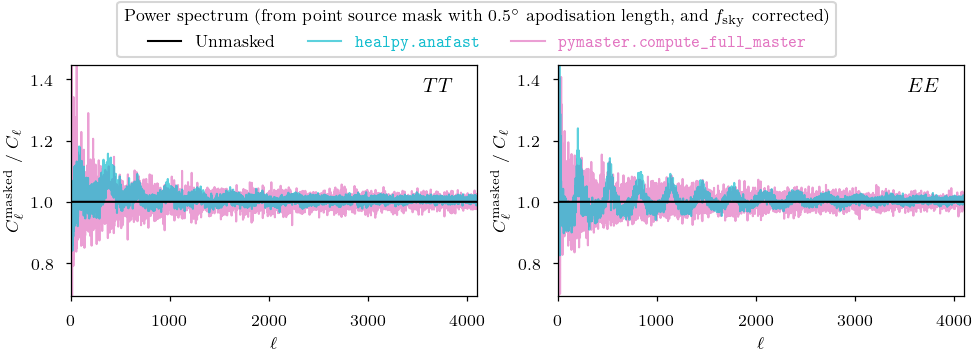

In [39]:

idx = 1
lmin = 2
lmax = 2048*2

fig, axes = plt.subplots(1, 2, figsize=(2.4*fw, fh), sharex=True)
for idx, ax in enumerate(axes):
    plotdls(ax, cnm_pts_apolow[idx]/cls_2048[idx],                 a=lmin, b=lmax, norm=False, c=c_pymstr, alpha=0.7, label=r"\texttt{pymaster.compute_full_master}")
    plotdls(ax, cls_pts_apolow[idx]/cls_2048[idx]/fsky_pts_apolow, a=lmin, b=lmax, norm=False, c=c_ptslow, alpha=0.7, label=r"\texttt{healpy.anafast}")
    plotdls(ax, cls_2048[idx]      /cls_2048[idx],                 a=lmin, b=lmax, norm=False, c='black',  alpha=1.0, label=r"Unmasked")
    ax.set_xlim(0, lmax)
    ax.set_ylim(10**-0.16, 10**0.16)
    ax.set_ylabel(f'$C_\\ell^\\mathrm{{masked}}~/~C_\\ell$')
    ax.text(0.9, 0.95, f"${labels_v[idx]}$", va='top', ha='center', transform=ax.transAxes, fontsize='large')
    ax.plot([], [], c='w', alpha=0, label=" ")
handles, labels = ax.get_legend_handles_labels()
order = [-2, 1, 0]
axes[0].legend(
    np.array(handles)[order],
    np.array(labels)[order],
    title=fr"Power spectrum (from point source mask with \ang{{{alow};;}} apodisation length, and $f_\mathrm{{sky}}$ corrected)",
    ncol=3,
    loc='lower center',
    bbox_to_anchor=(1, 1),
    labelcolor='linecolor',
)

plt.savefig("Figures/cls_healpy_vs_pymaster.pdf")
